In [15]:
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import matplotlib.pyplot as plt
import glob
from copy import deepcopy
import sys
import os
np.set_printoptions(threshold=sys.maxsize)
sys.path.insert(1, '../pretrain-data-prep')
# https://github.com/smart-pix/pretrain-data-prep/tree/main
from dataset_utils import quantize_manual, add_noise

# Create training dataset from flat pT PixelAV datasets

In [16]:
# Global variables
threshold = 0.2
pixel_arrayX = 21 #16 #
pixel_arrayY = 13 #16 #
noise_threshold = 0
qm_charge_levels = [400, 1600, 2400]
qm_quant_values = [0,1,2,3]
y_local_bins = np.linspace(-8.1, 8.1, 13)
bin_number = 6
y_local_min, y_local_max = y_local_bins[bin_number], y_local_bins[bin_number+1]
sensor_geom = '50x12P5'
train_dataset_name = 'dataset8' # for train datasets
test_dataset_name = 'dataset8' # for location of test (physical pT) datasets
dataset_savedir = f'dataset_8_{noise_threshold}NoiseThresh' # for save loc of final datasets
parquet_suffix = 16800 # 16400

# sensor_geom = '50x12P5_100e-sigma'
# train_dataset_name = 'dataset_3sNoise_16x16' # for train datasets
# test_dataset_name = 'dataset_2sNoise_16x16' # for location of test (physical pT) datasets
# dataset_savedir = f'dataset_2sNoise_16x16_50x12P5_100e-sigma_{noise_threshold}NoiseThresh' # for save loc of final datasets
if not os.path.exists(dataset_savedir):
    os.makedirs(dataset_savedir)

In [17]:
def sumRow(X):
        X = np.where(X < noise_threshold, 0, X)
        sum1 = 0
        sumList = []
        for i in X:
            sum1 = np.sum(i,axis=0)
            sumList.append(sum1)
            b = np.array(sumList)
        return b

In [18]:
dirtrain = '/asic/projects/C/CMS_PIX_28/pixelAV_datasets/unshuffled_DO_NOT_DELETE/initial_studies/'+train_dataset_name+'/unflipped/'
# dirtrain = '/asic/projects/C/CMS_PIX_28/pixelAV_datasets/unshuffled_DO_NOT_DELETE/'+train_dataset_name+'/'+train_dataset_name+'_'+sensor_geom+'_parquets/unflipped/'
dftrain = pd.read_parquet(f'{dirtrain}labels_d{parquet_suffix+1}.parquet')
print(dftrain.head())
print(dftrain.tail())

      x-entry    y-entry  z-entry       n_x       n_y       n_z  \
0   12.063666  30.923424    100.0  0.768970 -0.160933 -0.634940   
1   67.455246   4.533963    100.0 -1.205132 -0.087774 -0.635886   
2  -50.005310  -3.615270    100.0  1.542896 -0.322932 -1.512257   
3 -225.239441  13.836857    100.0  1.451834 -0.039285 -0.467361   
4   -2.914946  11.285143    100.0 -0.110369 -0.034764 -0.554253   

   number_eh_pairs  y-local        pt  cotAlpha   cotBeta  y-midplane  \
0          10034.0 -6.94104  0.656019 -1.211091  0.253462   18.250337   
1          15383.0 -4.33669  0.637776  1.895201  0.138034   -2.367746   
2          13968.0 -7.79379 -1.547540 -1.020260  0.213543  -14.292423   
3          26680.0 -2.67448  0.468860 -3.106451  0.084057    9.634003   
4           8183.0 -2.11685  0.555289  0.199131  0.062722    8.149030   

   x-midplane  
0   72.618207  
1  -27.304821  
2    1.007712  
3  -69.916896  
4  -12.871500  
          x-entry   y-entry  z-entry       n_x       n_y      

480  files present in directory.
iter_0:  650627
iter_1:  17544
iter_2:  19151
iter_rem:  0


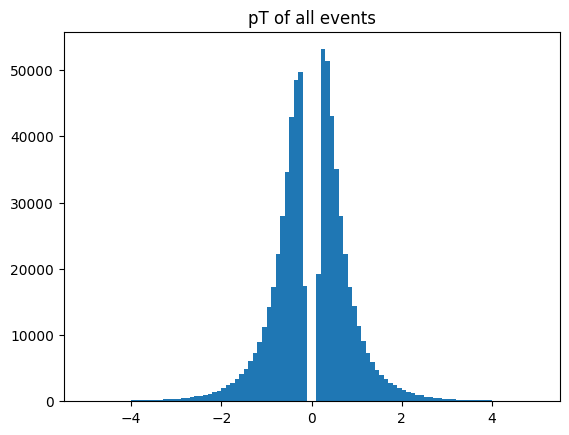

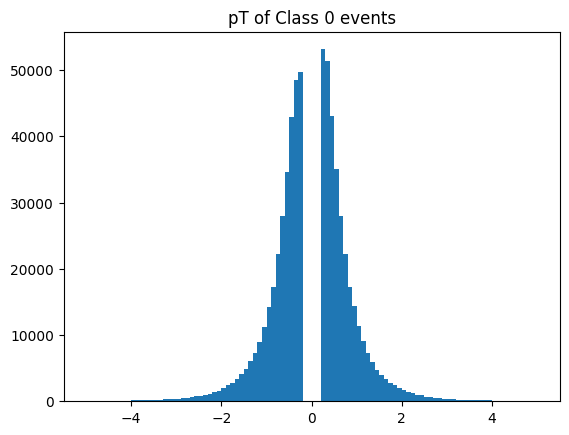

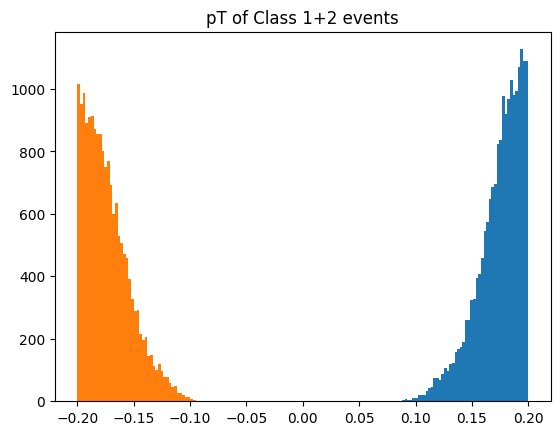

Number of events:  17000


In [19]:
trainlabels = []
trainrecons = []

iter=0
for filepath in glob.iglob(dirtrain+'labels*.parquet'):
    iter+=3
print(iter," files present in directory.")
for i in range(int(iter/3)):
        trainlabels.append(pd.read_parquet(dirtrain+'labels_d'+str(parquet_suffix+i+1)+'.parquet'))
        trainrecons.append(pd.read_parquet(dirtrain+'recon2D_d'+str(parquet_suffix+i+1)+'.parquet'))
trainlabels_csv = pd.concat(trainlabels, ignore_index=True)
trainrecons_csv = pd.concat(trainrecons, ignore_index=True)
# Retain events from only one y-local bin
filtered_indices = trainlabels_csv[(trainlabels_csv['y-local'] >= y_local_min) & (trainlabels_csv['y-local'] < y_local_max)].index
trainlabels_csv = trainlabels_csv.loc[filtered_indices].reset_index(drop=True)
trainrecons_csv = trainrecons_csv.loc[filtered_indices].reset_index(drop=True)

iter_0, iter_1, iter_2 = 0, 0, 0
iter_rem = 0
for iter, row in trainlabels_csv.iterrows():
    if(abs(row['pt'])>threshold):
        iter_0+=1
    elif(-1*threshold<=row['pt']<0):
        iter_1+=1
    elif(0<row['pt']<=threshold):
        iter_2+=1
    else:
        iter_rem+=1
print("iter_0: ",iter_0)
print("iter_1: ",iter_1)
print("iter_2: ",iter_2)
print("iter_rem: ",iter_rem)

plt.hist(trainlabels_csv['pt'], bins=100)
plt.title('pT of all events')
plt.show()

plt.hist(trainlabels_csv[abs(trainlabels_csv['pt'])>threshold]['pt'], bins=100)
plt.title('pT of Class 0 events')
plt.show()

plt.hist(trainlabels_csv[(0<=trainlabels_csv['pt'])&(trainlabels_csv['pt']<=threshold)]['pt'], bins=50)
plt.hist(trainlabels_csv[(-1*threshold<=trainlabels_csv['pt'])& (trainlabels_csv['pt']<0)]['pt'], bins=50)
plt.title('pT of Class 1+2 events')
plt.show()

number_of_events = (min(iter_1, iter_2)//1000)*1000
if(number_of_events*2>iter_0):
    number_of_events = (iter_0//1000)*1000/2
number_of_events = int(number_of_events)
print("Number of events: ",number_of_events)


## Quantize train data

In [20]:
trainrecons_csv.head()
trainrecons_csv_quantized = quantize_manual(trainrecons_csv, charge_levels=qm_charge_levels, quant_values=qm_quant_values, shuffled=True)
pd.options.display.max_columns = None
trainrecons_csv_quantized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## create y-profiles and final test data

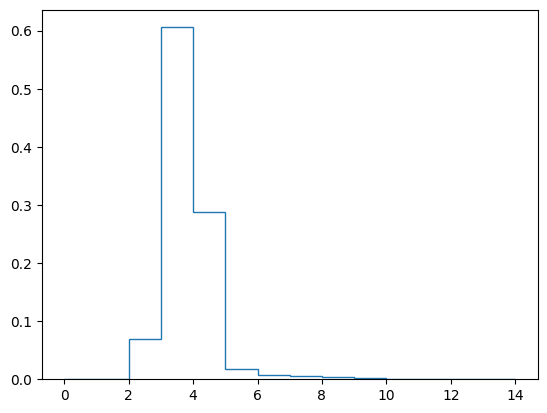

     0    1    2    3    4    5    6    7    8    9   10   11   12  cls  \
0  0.0  0.0  0.0  0.0  3.0  4.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0    0   
1  0.0  0.0  0.0  0.0  0.0  4.0  6.0  2.0  0.0  0.0  0.0  0.0  0.0    0   
2  0.0  0.0  0.0  3.0  4.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0   
3  0.0  0.0  0.0  3.0  3.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0   
4  0.0  0.0  0.0  3.0  3.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0   

         pt  
0  1.372050  
1 -0.710431  
2 -0.756973  
3  1.084860  
4  1.402360  


In [21]:
trainlist1, trainlist2 = [], []
hist_temp=[]
for (index1, row1), (index2, row2) in zip(trainrecons_csv_quantized.iterrows(), trainlabels_csv.iterrows()):
    rowSum = 0.0
    X = row1.values
    X = np.reshape(X,(pixel_arrayY,pixel_arrayX))
    rowSum = sumRow(X)
    hist_temp.append(np.sum(rowSum>0))
    trainlist1.append(rowSum)
    cls = -1
    if(abs(row2['pt'])>threshold):
        cls=0
    elif(-1*threshold<=row2['pt']<0):
        cls=1
    elif(0<=row2['pt']<=threshold):
        cls=2
    trainlist2.append([cls, row2['pt']])
    # trainlist2.append([row2['y-local'], cls, row2['pt']]) # y-local is not passed in ASIC DNN as there is one DNN per y-local bin.

plt.hist(hist_temp, bins=14,  range=[0, 14], histtype='step', fill=False, density=True)
plt.show()
traindf_all = pd.concat([pd.DataFrame(trainlist1), pd.DataFrame(trainlist2 , columns=['cls', 'pt'])], axis=1)
# traindf_all = pd.concat([pd.DataFrame(trainlist1), pd.DataFrame(trainlist2 , columns=['y-local', 'cls', 'pt'])], axis=1)
print(traindf_all.head())

In [23]:
totalsize = number_of_events
random_seed0 = 10#11
random_seed1 = 13#14
random_seed2 = 19#20

traindf_all = traindf_all.sample(frac=1, random_state=random_seed0).reset_index(drop=True)
# traindf_all.to_csv(dataset_savedir+'/'+'/FullTrainData_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
traindfcls0 = traindf_all.loc[traindf_all['cls']==0]
traindfcls1 = traindf_all.loc[traindf_all['cls']==1]
traindfcls2 = traindf_all.loc[traindf_all['cls']==2]
print(traindfcls0.shape)
print(traindfcls1.shape)
print(traindfcls2.shape)
print(traindfcls2.head())
# don't create balanced dataset as only 2000 events present in class 1/2 for 6th y-local bin
traindfcls0 = traindfcls0.iloc[:2*totalsize]
traindfcls1 = traindfcls1.iloc[:totalsize]
traindfcls2 = traindfcls2.iloc[:totalsize]
print(traindfcls2.head())

traincls0 = traindfcls0.sample(frac = 1, random_state=random_seed1)
traincls1 = traindfcls1.sample(frac = 1, random_state=random_seed1)
traincls2 = traindfcls2.sample(frac = 1, random_state=random_seed1)
train = pd.concat([traincls0, traincls1, traincls2], axis=0)

train = train.sample(frac=1, random_state=random_seed2)

print(traincls0.shape)
print(traincls1.shape)
print(traincls2.shape)
print(train.shape)

trainlabel = train['cls']
trainpt = train['pt']
train = train.drop(['cls', 'pt'], axis=1)

print(train.shape)
print(trainlabel.shape)
print(trainpt.shape)

train.to_csv(dataset_savedir+'/FullPrecisionInputTrainSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
trainlabel.to_csv(dataset_savedir+'/TrainSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
trainpt.to_csv(dataset_savedir+'/TrainSetPt_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)

(650627, 15)
(17544, 15)
(19151, 15)
       0    1    2    3    4    5    6    7    8    9   10   11   12  cls  \
4    0.0  0.0  1.0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    2   
83   0.0  0.0  1.0  4.0  3.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    2   
103  0.0  0.0  0.0  1.0  3.0  3.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0    2   
107  0.0  0.0  1.0  8.0  9.0  8.0  5.0  3.0  2.0  0.0  0.0  0.0  0.0    2   
111  0.0  0.0  0.0  0.0  4.0  6.0  5.0  1.0  0.0  0.0  0.0  0.0  0.0    2   

           pt  
4    0.181770  
83   0.164853  
103  0.154875  
107  0.126408  
111  0.156576  
       0    1    2    3    4    5    6    7    8    9   10   11   12  cls  \
4    0.0  0.0  1.0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    2   
83   0.0  0.0  1.0  4.0  3.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    2   
103  0.0  0.0  0.0  1.0  3.0  3.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0    2   
107  0.0  0.0  1.0  8.0  9.0  8.0  5.0  3.0  2.0  0.0  0.0  0.0  0.0    2   
111  0.0  0.0  0.0 

# Create test datasets from physical PixelAV dataset

In [24]:
dirtest = '/asic/projects/C/CMS_PIX_28/pixelAV_datasets/unshuffled_DO_NOT_DELETE/initial_studies/'+test_dataset_name+'/unflipped/'
# dirtest = '/asic/projects/C/CMS_PIX_28/pixelAV_datasets/unshuffled_DO_NOT_DELETE/'+test_dataset_name+'/'+test_dataset_name+'_'+sensor_geom+'_parquets/unflipped/'
# /location/of/parquets/smartpixels/dataset_2s/dataset_2s_50x12P5_parquets/unflipped
dftest = pd.read_parquet(f'{dirtest}labels_d{parquet_suffix+1}.parquet')
print(dftest.head())
print(dftest.tail())

      x-entry    y-entry  z-entry       n_x       n_y       n_z  \
0   12.063666  30.923424    100.0  0.768970 -0.160933 -0.634940   
1   67.455246   4.533963    100.0 -1.205132 -0.087774 -0.635886   
2  -50.005310  -3.615270    100.0  1.542896 -0.322932 -1.512257   
3 -225.239441  13.836857    100.0  1.451834 -0.039285 -0.467361   
4   -2.914946  11.285143    100.0 -0.110369 -0.034764 -0.554253   

   number_eh_pairs  y-local        pt  cotAlpha   cotBeta  y-midplane  \
0          10034.0 -6.94104  0.656019 -1.211091  0.253462   18.250337   
1          15383.0 -4.33669  0.637776  1.895201  0.138034   -2.367746   
2          13968.0 -7.79379 -1.547540 -1.020260  0.213543  -14.292423   
3          26680.0 -2.67448  0.468860 -3.106451  0.084057    9.634003   
4           8183.0 -2.11685  0.555289  0.199131  0.062722    8.149030   

   x-midplane  
0   72.618207  
1  -27.304821  
2    1.007712  
3  -69.916896  
4  -12.871500  
          x-entry   y-entry  z-entry       n_x       n_y      

480  files present in directory.
iter_0:  650627
iter_1:  17544
iter_2:  19151
iter_rem:  0


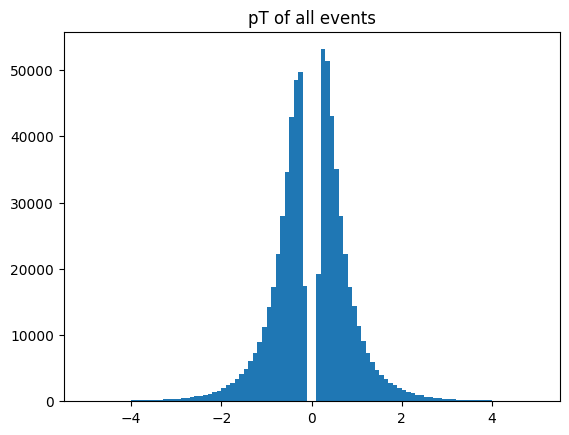

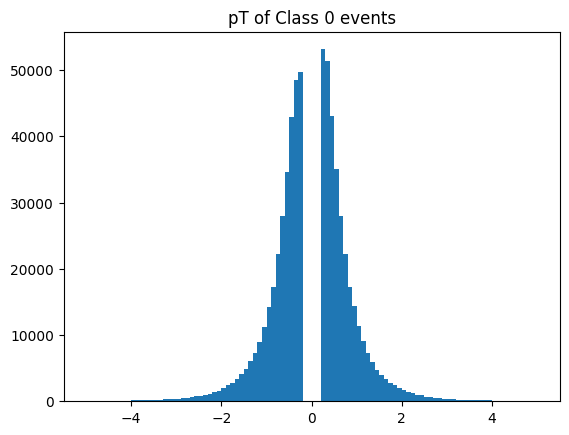

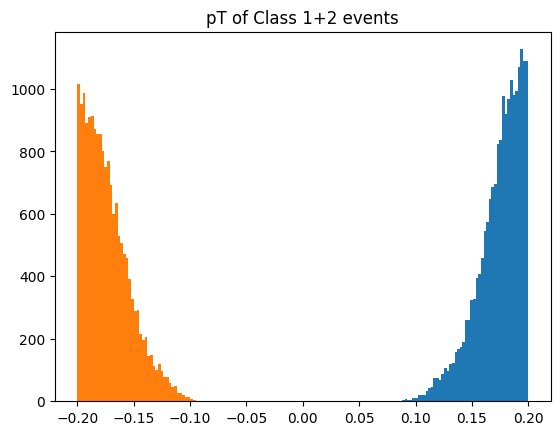

Number of events:  17000


In [25]:
testlabels = []
testrecons = []

iter=0
for filepath in glob.iglob(dirtest+'labels*.parquet'):
    iter+=3
print(iter," files present in directory.")
for i in range(int(iter/3)):
        testlabels.append(pd.read_parquet(dirtest+'labels_d'+str(parquet_suffix+i+1)+'.parquet'))
        testrecons.append(pd.read_parquet(dirtest+'recon2D_d'+str(parquet_suffix+i+1)+'.parquet'))
testlabels_csv = pd.concat(testlabels, ignore_index=True)
testrecons_csv = pd.concat(testrecons, ignore_index=True)

# Retain events from only one y-local bin
filtered_indices = testlabels_csv[(testlabels_csv['y-local'] >= y_local_min) & (testlabels_csv['y-local'] < y_local_max)].index
testlabels_csv = testlabels_csv.loc[filtered_indices].reset_index(drop=True)
testrecons_csv = testrecons_csv.loc[filtered_indices].reset_index(drop=True)

iter_0, iter_1, iter_2 = 0, 0, 0
iter_rem = 0
for iter, row in testlabels_csv.iterrows():
    if(abs(row['pt'])>threshold):
        iter_0+=1
    elif(-1*threshold<=row['pt']<0):
        iter_1+=1
    elif(0<row['pt']<=threshold):
        iter_2+=1
    else:
        iter_rem+=1
print("iter_0: ",iter_0)
print("iter_1: ",iter_1)
print("iter_2: ",iter_2)
print("iter_rem: ",iter_rem)

plt.hist(testlabels_csv['pt'], bins=100)
plt.title('pT of all events')
plt.show()

plt.hist(testlabels_csv[abs(testlabels_csv['pt'])>threshold]['pt'], bins=100)
plt.title('pT of Class 0 events')
plt.show()

plt.hist(testlabels_csv[(0<=testlabels_csv['pt'])&(testlabels_csv['pt']<=threshold)]['pt'], bins=50)
plt.hist(testlabels_csv[(-1*threshold<=testlabels_csv['pt'])& (testlabels_csv['pt']<0)]['pt'], bins=50)
plt.title('pT of Class 1+2 events')
plt.show()

number_of_events = (min(iter_1, iter_2)//1000)*1000
if(number_of_events*2>iter_0):
    number_of_events = (iter_0//1000)*1000/2
number_of_events = int(number_of_events)
print("Number of events: ",number_of_events)


## Quantize test data

In [26]:
testrecons_csv.head()
testrecons_csv_quantized = quantize_manual(testrecons_csv, charge_levels=qm_charge_levels, quant_values=qm_quant_values, shuffled=True)
pd.options.display.max_columns = None
testrecons_csv_quantized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [27]:
testlist1, testlist2 = [], []

for (index1, row1), (index2, row2) in zip(testrecons_csv_quantized.iterrows(), testlabels_csv.iterrows()):
    rowSum = 0.0
    X = row1.values
    X = np.reshape(X,(pixel_arrayY,pixel_arrayX))
    rowSum = sumRow(X)
    testlist1.append(rowSum)
    cls = -1
    if(abs(row2['pt'])>threshold):
        cls=0
    elif(-1*threshold<=row2['pt']<0):
        cls=1
    elif(0<=row2['pt']<=threshold):
        cls=2
    testlist2.append([cls, row2['pt']])
testdf_all = pd.concat([pd.DataFrame(testlist1), pd.DataFrame(testlist2 , columns=['cls', 'pt'])], axis=1)
print(testdf_all.head())

     0    1    2    3    4    5    6    7    8    9   10   11   12  cls  \
0  0.0  0.0  0.0  0.0  3.0  4.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0    0   
1  0.0  0.0  0.0  0.0  0.0  4.0  6.0  2.0  0.0  0.0  0.0  0.0  0.0    0   
2  0.0  0.0  0.0  3.0  4.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0   
3  0.0  0.0  0.0  3.0  3.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0   
4  0.0  0.0  0.0  3.0  3.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0   

         pt  
0  1.372050  
1 -0.710431  
2 -0.756973  
3  1.084860  
4  1.402360  


In [28]:
# totalsize = number_of_events#227000
random_seed0 = 10#11
random_seed1 = 13#14
random_seed2 = 19#20

testdf_all = testdf_all.sample(frac=1, random_state=random_seed0).reset_index(drop=True)
testdf_all.to_csv(dataset_savedir+'/'+'/FullTestData_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
# testdfcls0 = testdf_all.loc[testdf_all['cls']==0]
# testdfcls1 = testdf_all.loc[testdf_all['cls']==1]
# testdfcls2 = testdf_all.loc[testdf_all['cls']==2]
# print(testdfcls0.shape)
# print(testdfcls1.shape)
# print(testdfcls2.shape)
# print(testdfcls2.head())
# testdfcls0 = testdfcls0.iloc[:2*totalsize]
# testdfcls1 = testdfcls1.iloc[:totalsize]
# testdfcls2 = testdfcls2.iloc[:totalsize]
# print(testdfcls2.head())

# testcls0 = testdfcls0.sample(frac = 1, random_state=random_seed1)
# testcls1 = testdfcls1.sample(frac = 1, random_state=random_seed1)
# testcls2 = testdfcls2.sample(frac = 1, random_state=random_seed1)
# test = pd.concat([testcls0, testcls1, testcls2], axis=0)

# test = test.sample(frac=1, random_state=random_seed2)
test=testdf_all
# print(testcls0.shape)
# print(testcls1.shape)
# print(testcls2.shape)
print(test.shape)

testlabel = test['cls']
testpt = test['pt']
test = test.drop(['cls', 'pt'], axis=1)

print(test.shape)
print(testlabel.shape)
print(testpt.shape)

test.to_csv(dataset_savedir+'/FullPrecisionInputTestSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
testlabel.to_csv(dataset_savedir+'/TestSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
testpt.to_csv(dataset_savedir+'/TestSetPt_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)

(687322, 15)
(687322, 13)
(687322,)
(687322,)
